In [111]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import accuracy_score,log_loss
%matplotlib inline



In [212]:
train_house = pd.read_csv('train_house_price.csv')
test_house = pd.read_csv('test_house_price.csv')
all_data = pd.concat((train_house.loc[:,'MSSubClass':'SaleCondition'],
                      test_house.loc[:,'MSSubClass':'SaleCondition']),ignore_index=True) 

In [213]:
### process NaN
all_data.loc[all_data['Alley'].isnull(),'Alley'] = 'NoAlley'
all_data.loc[all_data['MasVnrType'].isnull(),'MasVnrType'] = 'None'
all_data.loc[all_data['MasVnrType'] == 'None','MasVnrArea'] = 0
all_data.loc[all_data['MSZoning'].isnull(),'MSZoning'] = 'RL'
all_data.loc[all_data['Utilities'].isnull(),'Utilities'] = 'AllPub'
all_data.loc[all_data['Exterior2nd'].isnull(),'Exterior2nd'] = 'VinylSd'
all_data.loc[all_data['Exterior1st'].isnull(),'Exterior1st'] = 'VinylSd'
all_data.loc[all_data['BsmtQual'].isnull(),'BsmtQual'] = 'NoBasement'
all_data.loc[all_data['BsmtCond'].isnull(),'BsmtCond'] = 'NoBasement'
all_data.loc[all_data['BsmtExposure'].isnull(),'BsmtExposure'] = 'NoBasement'
all_data.loc[all_data['BsmtFinType1'].isnull(),'BsmtFinType1'] = 'NoBasement'
all_data.loc[all_data['BsmtFinType1'] == 'NoBasement','BsmtFinSF1'] = 0.0
all_data.loc[all_data['BsmtFinType2'].isnull(),'BsmtFinType2'] = 'NoBasement'
all_data.loc[all_data['BsmtFinType2'] == 'NoBasement','BsmtFinSF2'] = 0.0
all_data.loc[all_data['BsmtQual'] == 'NoBasement' ,'BsmtUnfSF'] = 0.0
all_data.loc[all_data['BsmtQual'] == 'NoBasement' , 'TotalBsmtSF'] = 0.0
all_data.loc[all_data['BsmtUnfSF'].isnull(),'BsmtUnfSF'] = all_data.BsmtUnfSF.median()
all_data.loc[all_data['BsmtFinSF1'].isnull(),'BsmtFinSF1'] = all_data.BsmtFinSF1.median()
all_data.loc[all_data['KitchenQual'].isnull(),'KitchenQual'] = 'TA'
all_data.loc[all_data['Functional'].isnull(),'Functional'] = 'Typ'
all_data.loc[all_data['FireplaceQu'].isnull(),'FireplaceQu'] = 'NoFireplace'
all_data.loc[all_data['GarageType'].isnull(),'GarageType'] = 'NoGarage'
all_data.loc[all_data['GarageFinish'].isnull(),'GarageFinish'] = 'NoGarage'
all_data.loc[all_data['GarageQual'].isnull(),'GarageQual'] = 'NoGarage'
all_data.loc[all_data['GarageCond'].isnull(),'GarageCond'] = 'NoGarage'
all_data.loc[all_data['PoolQC'].isnull(),'PoolQC'] = 'NoPool'
all_data.loc[all_data['Fence'].isnull(),'Fence'] = 'NoFence'
all_data.loc[all_data['MiscFeature'].isnull(),'MiscFeature'] = 'None'
all_data.loc[all_data['SaleType'].isnull(),'SaleType'] = 'WD'
all_data.loc[all_data['Electrical'].isnull(),'Electrical'] = 'SBrkr'
all_data.loc[all_data['BsmtFullBath'].isnull(),'BsmtFullBath'] = 0
all_data.loc[all_data['BsmtHalfBath'].isnull(),'BsmtHalfBath'] = 0
# only one is null and it has type Detchd
all_data.loc[all_data['GarageArea'].isnull(), 'GarageArea'] = all_data.loc[all_data['GarageType']=='Detchd', 'GarageArea'].mean()
all_data.loc[all_data['GarageCars'].isnull(), 'GarageCars'] = all_data.loc[all_data['GarageType']=='Detchd', 'GarageCars'].median()

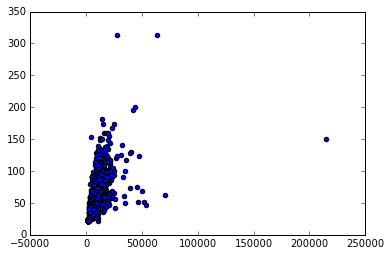

In [214]:
x = all_data.loc[np.logical_not(all_data["LotFrontage"].isnull()), "LotArea"]
y = all_data.loc[np.logical_not(all_data["LotFrontage"].isnull()), "LotFrontage"]
plt.scatter(x,y) ## delete outlier 
t = (x <= 25000 ) & (y <=150)
poly  = np.polyfit(x[t],y[t],1)
all_data.loc[all_data['LotFrontage'].isnull(),'LotFrontage'] = np.polyval(poly,all_data.loc[all_data['LotFrontage'].isnull(),'LotArea'])

In [215]:
all_data.loc[all_data['GarageYrBlt'].isnull(),'GarageYrBlt'] = all_data.GarageYrBlt.median()

In [233]:
x_train  = X_train_house2[:train_house.shape[0]]
x_test = X_train_house2[train_house.shape[0]:]

In [217]:
all_data = all_data.replace({
        #'MSZoning':{'A':1,'C':2,'FV':2,'RH':3,:'RL':4,'RP':4,'RM':4},
        'ExterQual':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
        'ExterCond':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
        'BsmtQual':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NoBasement':0},
        'BsmtCond':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NoBasement':0},
        'BsmtExposure':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NoBasement':0},
        'HeatingQC':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
        'KitchenQual':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
        'FireplaceQu':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NoFireplace':0},
        'GarageQual':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NoGarage':0},
        'GarageCond':{'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NoGarage':0},
        'PoolQC':{'Ex':4,'Gd':3,'TA':2,'Fa':1,'NoPool':0},
        'Street':{'Grvl':1,'Pave':2},
        'Alley':{'Grvl':1,'Pave':2,'NoAlley':3},
        'Utilities':{'AllPub':1,'NoSewr':2,'NoSeWa':3,'ELO':4},
        'Fence':{'GdPrv':1,'MnPrv':2,'GdWo':3,'MnWw':4,'NoFence':5},
        'Functional':{'Typ':0,'Min1':1,'Min2':1,'Mod':2,'Maj1':3,'Maj2':4,'Sev':5,'Sal':6},
        
    })

In [98]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [218]:
all_data = all_data.replace({
        'SaleCondition':{
            'Normal':1,
            'Abnorml':2,
            'AdjLand':3,
            'Alloca':4,
            'Family':5,
            'Partial':6,
        },
    })

In [109]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,2,3,Reg,Lvl,1,Inside,...,0,0,0,5,None,0,2,2008,WD,1
1,20,RL,80.0,9600,2,3,Reg,Lvl,1,FR2,...,0,0,0,5,None,0,5,2007,WD,1
2,60,RL,68.0,11250,2,3,IR1,Lvl,1,Inside,...,0,0,0,5,None,0,9,2008,WD,1
3,70,RL,60.0,9550,2,3,IR1,Lvl,1,Corner,...,0,0,0,5,None,0,2,2006,WD,2
4,60,RL,84.0,14260,2,3,IR1,Lvl,1,FR2,...,0,0,0,5,None,0,12,2008,WD,1


In [219]:
exter_qual = all_data['ExterQual'].copy()
exter_qual[exter_qual >=3 ] =1
exter_qual[exter_qual < 3 ] = 0 
exter_qual.name = 'ExterQual'
basement_qual = all_data['BsmtQual'].copy()
basement_qual[basement_qual >=3 ] =1
basement_qual[basement_qual <3 ] = 0
basement_qual.name = 'BsmtQual'
kitchen_qual = all_data['KitchenQual'].copy()
kitchen_qual[kitchen_qual >=3 ] = 1
kitchen_qual[kitchen_qual < 3 ] = 0
kitchen_qual.name = 'KitchenQual'
garage_qual = all_data['GarageQual'].copy()
garage_qual[garage_qual >=3 ] = 1
garage_qual[garage_qual < 3] = 0
garage_qual.name = 'GarageQual'
heating_qual = all_data['HeatingQC'].copy()
heating_qual[heating_qual >=3 ] =1
heating_qual[heating_qual < 3] = 0
heating_qual.name = 'HeatingQC'
overall_qual = all_data['OverallQual'].copy()
overall_qual = overal_qual - 5
overall_qual[overal_qual >=0  ] = 1
overall_qual[overal_qual < 0 ] =0 
overall_qual.name = 'OverallQual'
overall_cond = all_data['OverallCond'].copy()
overall_cond = overall_cond - 5
overall_cond[overall_cond >=0] = 1
overall_cond[overall_cond < 0] = 0
overall_cond.name = 'OverallCond'
basement_cond = all_data['BsmtCond'].copy()
basement_cond[basement_cond >=3] = 1
basement_cond[basement_cond < 3] = 0
basement_cond.name = 'BsmtCond'
qu_list = pd.concat((exter_qual,basement_qual,kitchen_qual,
           garage_qual,heating_qual,
           overall_qual,overall_cond,basement_cond),axis=1)

MasVnrType_Any = all_data['MasVnrType'].replace({'BrkCmn': 1,
                                              'BrkFace': 1,
                                              'CBlock': 1,
                                              'Stone': 1,
                                              'None': 0})
MasVnrType_Any.name = 'MasVnrType_Any'

In [220]:
X_train_house2 = pd.concat((qu_list,all_data['SaleCondition'],all_data['FireplaceQu'],
           all_data['GarageYrBlt'],all_data['PoolQC'],
          all_data['Fence'],all_data['Utilities'],all_data['Functional'],all_data['MSZoning']),axis=1)

In [156]:
X_train,X_valid ,y_train,y_valid = train_test_split(x_train,train_house['SalePrice'],test_size=0.2,random_state=42)
clf = RandomForestRegressor(n_estimators=150,max_depth=7)
clf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [234]:
clf.fit(x_train,train_house['SalePrice'])
y_pred = clf.predict(x_test)
pd.DataFrame({'Id':x_test.index+1,
               'SalePrice':y_pred}).to_csv('Home Price.csv',index=False)


In [223]:
X_train_house2['MSZoning'] = X_train_house2['MSZoning'].replace({
        'A':1,
        'C':2,
        'FV':2,
        'RH':2,
        'RL':1,
        'RP':2,
        'RM':2
    })
X_train_house2.head()

,ExterQual,BsmtQual,KitchenQual,GarageQual,HeatingQC,OverallQual,OverallCond,BsmtCond,SaleCondition,FireplaceQu,GarageYrBlt,PoolQC,Fence,Utilities,Functional,MSZoning
0,0,0,0,0,0,1,1,0,1,0,2003.0,0,5,1,0,1
1,0,0,0,0,0,1,1,0,1,3,1976.0,0,5,1,0,1
2,0,0,0,0,0,1,1,0,1,3,2001.0,0,5,1,0,1
3,0,0,0,0,0,1,1,0,2,4,1998.0,0,5,1,0,1
4,0,0,0,0,0,1,1,0,1,3,2000.0,0,5,1,0,1
